In [1]:
import os
import random

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

%matplotlib inline
plt.style.use('ggplot')

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import KFold, cross_validate
import pickle


Bad key "text.kerning_factor" on line 4 in
/Users/user/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
def csv_transfomer():
  data = open('data.csv',mode='w')
  data_files = ['combined_data_1.txt',
                'combined_data_2.txt',
                'combined_data_3.txt',
                'combined_data_4.txt'
              ]
  rating = list()
  for file in data_files:
    with open(file) as x:
      for line in x:
        del rating[:]
        line = line.strip()
        if line.endswith(':'):
          MovieID = line.replace(':','')
        else:
          rating = [x for x in line.split(',')]
          rating.insert(0,MovieID)
          data.write(','.join(rating))
          data.write('\n')
  data.close()

if os.path.isfile('data.csv'):
  os.remove('data.csv')
  csv_transfomer()

else:
  csv_transfomer()

In [2]:
df_ratings = pd.read_csv('data.csv', names=['MovieID','User', 'Rating', 'Date'])
df_ratings.Date = pd.to_datetime(df_ratings.Date)
movie_titles = pd.read_csv('movie_titles.csv',names = ['MovieID','YearOfRelease','Title'],delimiter=',',encoding = "ISO-8859-1")
df_ratings = df_ratings.merge(movie_titles,on='MovieID')

In [3]:
graph1 = go.Bar(    
                y = df_ratings.Rating.value_counts(),
                x = df_ratings.Rating.value_counts().index,
                marker = dict(color = ['#8B0000','#A52A2A','#B22222','#FF6347','#FFA07A'],
                              line = dict(color='rgb(100,100,100)',
                              width = 2))
              )
layout = go.Layout(title='<b>Count of movie ratings</b>',)
figure = go.Figure(data=graph1,layout=layout)
figure.update_layout(xaxis_title="Rating",
                     yaxis_title="Count of rates",)
pyo.iplot(figure)

In [4]:
titles_rating_mean = df_ratings.groupby('Title').Rating.mean().sort_values(ascending=False).map(lambda x: round(x,2))
print('-------------------------------- Best rated titles --------------------------------')
titles_rating_mean.head(10)

-------------------------------- Best rated titles --------------------------------


Title
Lord of the Rings: The Return of the King: Extended Edition            4.72
The Lord of the Rings: The Fellowship of the Ring: Extended Edition    4.72
Lord of the Rings: The Two Towers: Extended Edition                    4.70
Lost: Season 1                                                         4.67
Battlestar Galactica: Season 1                                         4.64
Fullmetal Alchemist                                                    4.61
Trailer Park Boys: Season 3                                            4.60
Trailer Park Boys: Season 4                                            4.60
Tenchi Muyo! Ryo Ohki                                                  4.60
The Shawshank Redemption: Special Edition                              4.59
Name: Rating, dtype: float64

In [5]:
Q_ratings_by_title = df_ratings.groupby('Title').Rating.count().sort_values(ascending=False).map(lambda x: str('{:,}'.format(x)))
print('-------------------------------- Most rated titles --------------------------------')
Q_ratings_by_title.head(10)

-------------------------------- Most rated titles --------------------------------


Title
Miss Congeniality                                         232,944
Independence Day                                          216,596
The Patriot                                               211,764
The Godfather                                             206,551
The Day After Tomorrow                                    196,397
Pirates of the Caribbean: The Curse of the Black Pearl    193,941
Pretty Woman                                              193,295
Twister                                                   187,808
Gone in 60 Seconds                                        183,590
Forrest Gump                                              181,508
Name: Rating, dtype: object

In [6]:
graph1 = go.Scatter(    
                    x = df_ratings.YearOfRelease.value_counts().sort_index().index,
                    y = df_ratings.YearOfRelease.value_counts().sort_index(),
                    mode ='lines',
                    marker = dict(color = '#CD5C5C')
              )
layout = go.Layout(title='<b>Count of titles released by year</b>',)
figure = go.Figure(data=graph1,layout=layout)
figure.update_layout(xaxis_title="Year of release",
                     yaxis_title="Count of titles released",)
pyo.iplot(figure)

In [7]:
df2_ratings = pd.DataFrame(df_ratings.groupby('Title').Rating.mean())
df2_ratings['Q_ratings'] = pd.DataFrame(df_ratings.groupby('Title').Rating.count())

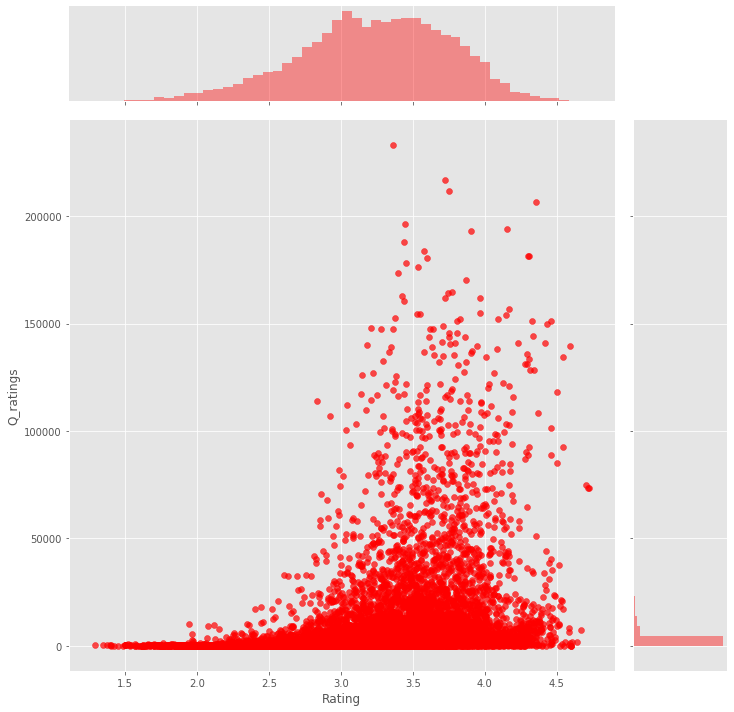

In [8]:
sns.jointplot(data=df2_ratings,x= 'Rating',y='Q_ratings',alpha=0.7,color='red',height=10)

In [9]:
fig = px.histogram(df2_ratings, x="Rating",nbins=80,
                   color_discrete_sequence=['firebrick'],opacity=0.7,
                   histnorm='probability density',
                   title='<b>AVG Rating Distribution</b>')
fig.show()

In [10]:
fig = px.histogram(df2_ratings, x="Q_ratings",nbins=50,
                   color_discrete_sequence=['firebrick'],opacity=0.7,
                   histnorm='probability')
fig.show()

In [14]:
n_users = df_ratings.User.nunique()
n_items = df_ratings.MovieID.nunique()
sparsity = round(1.0-len(df_ratings)/float(n_users*n_items),3)
print('The sparsity level is ' +  str(sparsity*100) + '%')
del n_users, n_items

The sparsity level is 98.8%


In [15]:
users_filtering = (df_ratings.User.value_counts()>600)
users_filtering = users_filtering[users_filtering].index.tolist()
movies_filtering = (df_ratings.MovieID.value_counts()>40000)
movies_filtering = movies_filtering[movies_filtering].index.tolist()
df2 = df_ratings[(df_ratings.User.isin(users_filtering)) & (df_ratings.MovieID.isin(movies_filtering))][['MovieID','User','Rating']]
del users_filtering, movies_filtering, df_ratings

In [16]:
reader = Reader(rating_scale=(1, 5.0))
data = Dataset.load_from_df(df2, reader)
del df2, reader

kf = KFold(n_splits=4)
algo = SVD()
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions,verbose=True)
del data

#data.split(n_folds=5)
#algo = SVD()
#cross_validate(algo,data,measures=['RMSE'],cv=5,verbose=True)

RMSE: 0.7832
RMSE: 0.7835
RMSE: 0.7827
RMSE: 0.7830


In [17]:
model_filename = 'netflix_fitted_model.sav'
#pickle.dump(algo,open(filename, 'wb')) # To save the model
algo = pickle.load(open(model_filename, 'rb')) # To load the model

In [18]:
def MovieRecomendation(user):
  rate = []
  movie_id = []
  for i in df2.MovieID.unique():
    rate.append(round(algo.predict(user,i)[3],2))
    movie_id.append(i)
    top_results = pd.DataFrame({'MovieID':movie_id,'Rating':rate}).join(movie_titles.set_index('MovieID'),on='MovieID').sort_values(by='Rating',ascending=False).head(20)
  return top_results.set_index('MovieID')[['Title','YearOfRelease','Rating']]

In [21]:
random_user = random.choice(df2.User.to_list())
print('The user ID randomly selected is {}, and we recommend the following titles due to what he/she has rated:\n'.format(random_user))
MovieRecomendation(random_user)

The user ID randomly selected is 1378890, and we recommend the following titles due to what he/she has rated:



Title  YearOfRelease  \
MovieID                                                                     
7057     Lord of the Rings: The Two Towers: Extended Ed...         2002.0   
3962                             Finding Nemo (Widescreen)         2003.0   
14961    Lord of the Rings: The Return of the King: Ext...         2003.0   
7230     The Lord of the Rings: The Fellowship of the R...         2001.0   
9254                                           The Goonies         1985.0   
14240            Lord of the Rings: The Return of the King         2003.0   
13673                                            Toy Story         1995.0   
5582         Star Wars: Episode V: The Empire Strikes Back         1980.0   
9628             Star Wars: Episode VI: Return of the Jedi         1983.0   
16265                    Star Wars: Episode IV: A New Hope         1977.0   
10820                                   Back to the Future         1985.0   
14621                                  Shrek (Full-screen)         2001.0   
3938                                               Shrek 2         2004.0   
7193                                    The Princess Bride         1987.0   
10947                                      The Incredibles         2004.0   
11089                                             Monsters         2001.0   
10042                              Raiders of the Lost Ark         1981.0   
3605                 The Wizard of Oz: Collector's Edition         1939.0   
2452         Lord of the Rings: The Fellowship of the Ring         2001.0   
14050                  Willy Wonka & the Chocolate Factory         1971.0   

         Rating  
MovieID          
7057       4.79  
3962       4.78  
14961      4.75  
7230       4.73  
9254       4.72  
14240      4.71  
13673      4.66  
5582       4.65  
9628       4.65  
16265      4.64  
10820      4.64  
14621      4.63  
3938       4.63  
7193       4.62  
10947      4.60  
11089      4.57  
10042      4.56  
3605       4.56  
2452       4.55  
14050      4.55